In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
grn = pd.read_csv('../data/otb-sept-2023/grn.csv')
grn['date'] = pd.to_datetime(grn['date'], format='%d/%m/%Y')
grn['ean'] = grn['ean'].astype(int)
grn['qty'] = grn['qty'].astype(int)
grn = grn[~grn['ean'].astype(str).str.startswith('59')]

sales = pd.read_csv('../data/otb-sept-2023/sales.csv')
sales['date'] = pd.to_datetime(sales['date'], format='%d-%m-%Y')
sales['ean'] = sales['ean'].astype(int)
sales['qty'] = sales['qty'].astype(int)
sales = sales[sales['qty'] > 0]

soh = pd.read_csv('../data/otb-sept-2023/soh.csv')
soh['ean'] = soh['ean'].astype(int)
soh['qty'] = soh['qty'].astype(int)
soh['date'] = pd.to_datetime(soh['date'], format='%d-%m-%Y')

In [3]:
def analyse(df, type):
    monthly = df.groupby(['ean', pd.Grouper(key='date', freq='M')]).agg({'qty': 'sum'})
    monthly['pct_change'] = monthly.groupby('ean')['qty'].pct_change()*100
    pivot = monthly.pivot_table(index='ean', columns='date', values='qty')
    pivot.columns = [f'{type}_' + col.strftime('%b') for col in pivot.columns]
    pivot[f'{type}_trend'] = monthly.groupby('ean')['pct_change'].mean().sort_values(ascending=False)
    return pivot

In [4]:
sales = analyse(sales, 'sales')
soh = analyse(soh, 'soh')
grn = analyse(grn, 'grn')

all_combined = pd.merge(sales, grn, on='ean', how='outer')
all_combined = pd.merge(all_combined, soh, on='ean', how='outer')
all_combined = all_combined.round(2)

all_combined['soh_trend_grade'] = np.where(all_combined['soh_trend'] > 400, 'up', np.where(all_combined['soh_trend'] > 0, 'flat', 'down'))
all_combined['sales_trend_grade'] = np.where(all_combined['sales_trend'] > 400, 'up', np.where(all_combined['sales_trend'] > 0, 'flat', 'down'))
all_combined['grn_trend_grade'] = np.where(all_combined['grn_trend'] > 1, 'bad', np.where(all_combined['grn_trend'] > -1, 'good', 'bad'))
all_combined.fillna(0, inplace=True)

all_combined.to_csv('../data/otb-sept-2023/analyzed.csv')

all_combined[(all_combined['soh_trend_grade'] == 'up') & (all_combined['sales_trend_grade'] == 'down')].to_csv('../data/otb-sept-2023/overstocked.csv')
all_combined[(all_combined['soh_trend_grade'] == 'down') & (all_combined['sales_trend_grade'] == 'up')].to_csv('../data/otb-sept-2023/understocked.csv')

<AxesSubplot: >

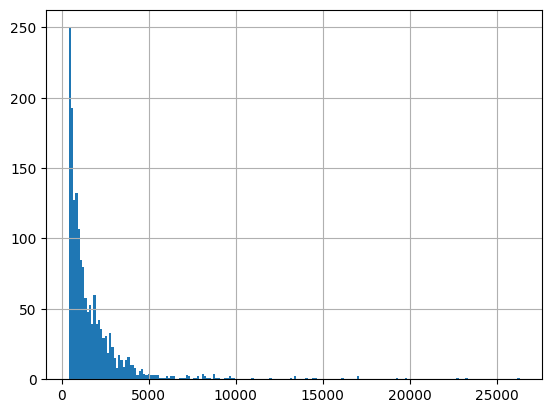

In [5]:
all_combined[all_combined['soh_trend']>400].soh_trend.hist(bins=200)

<AxesSubplot: >

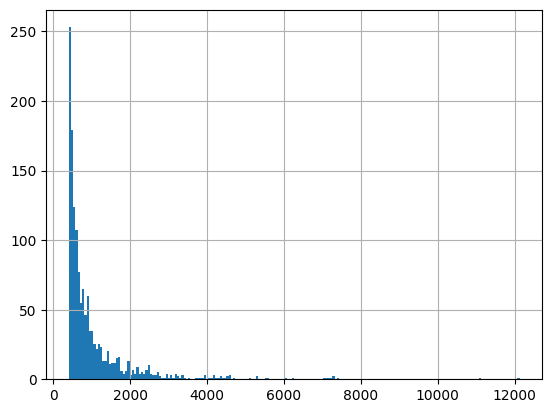

In [6]:
all_combined[all_combined['sales_trend']>400].sales_trend.hist(bins=200)

<AxesSubplot: >

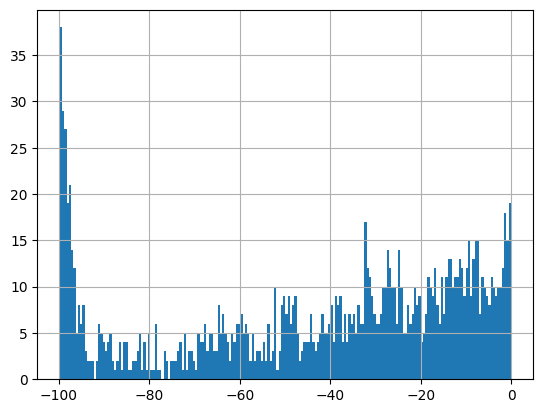

In [7]:
all_combined[all_combined['grn_trend']<0].grn_trend.hist(bins=200)